In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp

### 1.Загрузка данных

In [5]:
df = pd.read_csv('../../../../data/Iris.csv', index_col='Id')
print(df.count())
df.head()

SepalLengthCm    150
SepalWidthCm     150
PetalLengthCm    150
PetalWidthCm     150
Species          150
dtype: int64


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


### 2.Предварительная обработка

In [6]:
!pip install keras

You are using pip version 8.1.2, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [5]:
!pip install  tensorflow

You are using pip version 8.1.2, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [33]:
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical

In [34]:
class FillNa(TransformerMixin, BaseEstimator):
    def fit(self, df: pd.DataFrame, y=None):
        return self
    
    def transform(self, df: pd.DataFrame, y=None) -> pd.DataFrame:
        return df.interpolate(method='cubic').fillna(method='pad').dropna()
    

class DropOutlet(TransformerMixin, BaseEstimator):
    def fit(self, df: pd.DataFrame, y=None):
        self.std = df.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, df: pd.DataFrame, y=None) -> pd.DataFrame:
        df_cols = df[self.columns]
        return df[ (df_cols - df_cols.mean()).abs() <= 3*self.std].dropna()
    
    
class PandasToNumpy(BaseEstimator):
    def fit(self, data : pd.DataFrame, y=None):
        return self
    
    def transform(self, data: pd.DataFrame, y=None) -> np.ndarray:
        return data.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        return df.toarray()
    
    
class ModifyLabelEncoder(preprocessing.LabelEncoder):
    def fit(self, df, y=None):
        return super().fit(df)
    
    def transform(self, df, y=None):
        return super().transform(df)
    
    def fit_transform(self, df, y=None):
        return super().fit_transform(df)
    
class ExpandDims(TransformerMixin, BaseEstimator):
    """
    Увеличение на 1 размерности массива в нужной оси 
    """
    def __init__(self, axis):
        self.axis = axis
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        return np.expand_dims(df, axis=self.axis)
        
    

In [35]:
x_data = df[df.columns[:-1]].copy()
# в числовых данных getdummies не даст эффекта АСТАНАВИТЕС

In [36]:
y_data = df[df.columns[-1]].copy()

In [11]:
fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa())
])
pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet())
])

outletless_data_x = pipe_outlet.fit_transform(x_data)

In [12]:
outletless_data_y = y_data[fill_na_pipe.transform(y_data).index.isin(outletless_data_x.index) ]

In [13]:
pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

In [14]:
pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1)),
    ('one_hot_encoder', preprocessing.OneHotEncoder(sparse=False)),
])

In [15]:
number_data_x = pipe_x.fit_transform(outletless_data_x)
number_data_y = pipe_y.fit_transform(outletless_data_y)

print(number_data_x.shape, number_data_y.shape)

(149, 4) (149, 3)


In [16]:
number_data_x[:10,:], number_data_y[::10]

(array([[ 0.22222222,  0.68181818,  0.06779661,  0.04166667],
        [ 0.16666667,  0.45454545,  0.06779661,  0.04166667],
        [ 0.11111111,  0.54545455,  0.05084746,  0.04166667],
        [ 0.08333333,  0.5       ,  0.08474576,  0.04166667],
        [ 0.19444444,  0.72727273,  0.06779661,  0.04166667],
        [ 0.30555556,  0.86363636,  0.11864407,  0.125     ],
        [ 0.08333333,  0.63636364,  0.06779661,  0.08333333],
        [ 0.19444444,  0.63636364,  0.08474576,  0.04166667],
        [ 0.02777778,  0.40909091,  0.06779661,  0.04166667],
        [ 0.16666667,  0.5       ,  0.08474576,  0.        ]]),
 array([[ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.]]))

### 3.Построение нейронной сети

In [104]:
x_train = number_data_x
y_train = number_data_y
x_train.shape, y_train.shape

((149, 4), (149, 3))

In [105]:
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop

In [106]:
model = Sequential()
model.add(Dense(10, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(Adam(), 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [107]:
model.fit(x_train,
          y_train,
          verbose=2,
          epochs=100,
          batch_size=3)

Epoch 1/100
 - 0s - loss: 1.0757 - categorical_accuracy: 0.3356
Epoch 2/100
 - 0s - loss: 1.0508 - categorical_accuracy: 0.3557
Epoch 3/100
 - 0s - loss: 1.0270 - categorical_accuracy: 0.3893
Epoch 4/100
 - 0s - loss: 1.0025 - categorical_accuracy: 0.5436
Epoch 5/100
 - 0s - loss: 0.9749 - categorical_accuracy: 0.6376
Epoch 6/100
 - 0s - loss: 0.9457 - categorical_accuracy: 0.6644
Epoch 7/100
 - 0s - loss: 0.9137 - categorical_accuracy: 0.6644
Epoch 8/100
 - 0s - loss: 0.8792 - categorical_accuracy: 0.6913
Epoch 9/100
 - 0s - loss: 0.8443 - categorical_accuracy: 0.7718
Epoch 10/100
 - 0s - loss: 0.8088 - categorical_accuracy: 0.7517
Epoch 11/100
 - 0s - loss: 0.7735 - categorical_accuracy: 0.6779
Epoch 12/100
 - 0s - loss: 0.7377 - categorical_accuracy: 0.6644
Epoch 13/100
 - 0s - loss: 0.7057 - categorical_accuracy: 0.6644
Epoch 14/100
 - 0s - loss: 0.6744 - categorical_accuracy: 0.7248
Epoch 15/100
 - 0s - loss: 0.6472 - categorical_accuracy: 0.7852
Epoch 16/100
 - 0s - loss: 0.6201 

In [108]:
model.evaluate(x_train, y_train)

149/149 [==============================] - 0s 837us/step


[0.13940361902217738, 0.95973154402419225]

### 5. Построение усложненного варианта НС

In [109]:
from keras import callbacks

In [110]:
xy_data = np.hstack( (number_data_x, number_data_y) ).transpose( (0,1))
np.random.shuffle(xy_data)

point_split = round(xy_data.shape[0] * 0.8)
train_data = xy_data[:point_split]
test_data = xy_data[point_split:]

print('Всего данных: '+str(xy_data.shape[0]))
print('Тренировочных данных: '+str(train_data.shape[0]))
print('Тестовых данных: '+str(test_data.shape[0]))

x_train = train_data[:, :number_data_x.shape[1] ]
y_train = train_data[:, :number_data_y.shape[1] ]

print('Размер данные для тренировки (входных): '+str(x_train.shape))
print('Размер данные для тренировки (выходных): '+str(y_train.shape))

x_test = test_data[:, :number_data_x.shape[1] ]
y_test = test_data[:, :number_data_y.shape[1] ]

print('Размер данные для теста (входных): '+str(x_test.shape))
print('Размер данные для теста (выходных): '+str(x_test.shape))

Всего данных: 149
Тренировочных данных: 119
Тестовых данных: 30
Размер данные для тренировки (входных): (119, 4)
Размер данные для тренировки (выходных): (119, 3)
Размер данные для теста (входных): (30, 4)
Размер данные для теста (выходных): (30, 4)


In [111]:
def make_nn(input_len, output_len):
    model = Sequential(layers=(
        Dense(10, activation='relu', input_dim=input_len),
        Dense(output_len, activation='sigmoid')
        )
    )
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [112]:
model = make_nn(x_train.shape[1], y_train.shape[1])

print('Начинаем обучение')
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=3,
    epochs=100,
    verbose=1,
    validation_data=(x_test,y_test),
    callbacks=[
        callbacks.History()
    ]
)

Начинаем обучение
Train on 119 samples, validate on 30 samples
Epoch 1/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5106 - categorical_accuracy: 0.4286 - val_loss: 1.5306 - val_categorical_accuracy: 0.3667
Epoch 2/100
119/119 [==============================] - 0s 285us/step - loss: 1.4988 - categorical_accuracy: 0.4202 - val_loss: 1.5197 - val_categorical_accuracy: 0.3667
Epoch 3/100
119/119 [==============================] - 0s 310us/step - loss: 1.4899 - categorical_accuracy: 0.5630 - val_loss: 1.5095 - val_categorical_accuracy: 0.6000
Epoch 4/100
119/119 [==============================] - 0s 310us/step - loss: 1.4814 - categorical_accuracy: 0.7311 - val_loss: 1.5002 - val_categorical_accuracy: 0.8000
Epoch 5/100
119/119 [==============================] - 0s 310us/step - loss: 1.4738 - categorical_accuracy: 0.8655 - val_loss: 1.4905 - val_categorical_accuracy: 0.9667
Epoch 6/100
119/119 [==============================] - 0s 302us/step - loss: 1.4659 - categori

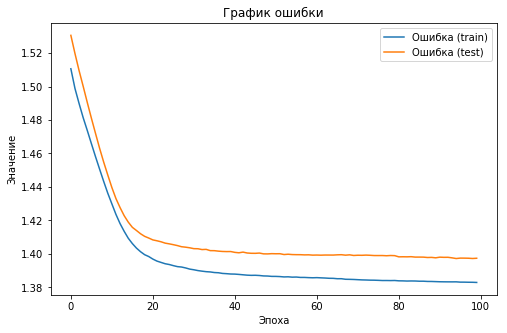

In [113]:
plt.figure(0, figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)'])

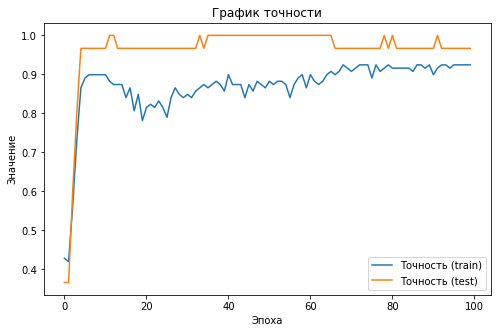

In [114]:
plt.figure(1, figsize=(8,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('График точности')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Точность (train)', 'Точность (test)'])

In [127]:
model = make_nn(number_data_x.shape[1], number_data_y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=3,
    epochs=100,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 95 samples, validate on 24 samples
Epoch 1/100
95/95 [==============================] - 1s 6ms/step - loss: 1.4871 - categorical_accuracy: 0.5789 - val_loss: 1.5562 - val_categorical_accuracy: 0.5417
Epoch 2/100
95/95 [==============================] - 0s 310us/step - loss: 1.4676 - categorical_accuracy: 0.5789 - val_loss: 1.5379 - val_categorical_accuracy: 0.5417
Epoch 3/100
95/95 [==============================] - 0s 315us/step - loss: 1.4566 - categorical_accuracy: 0.5474 - val_loss: 1.5265 - val_categorical_accuracy: 0.5833
Epoch 4/100
95/95 [==============================] - 0s 304us/step - loss: 1.4480 - categorical_accuracy: 0.8000 - val_loss: 1.5166 - val_categorical_accuracy: 0.7917
Epoch 5/100
95/95 [==============================] - 0s 310us/step - loss: 1.4402 - categorical_accuracy: 0.8316 - val_loss: 1.5061 - val_categorical_accuracy: 0.7917
Epoch 6/100
95/95 [==============================] - 0s 325us/step - loss: 1.4322 - categorical_accu

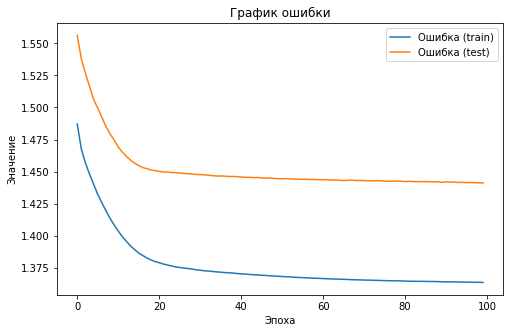

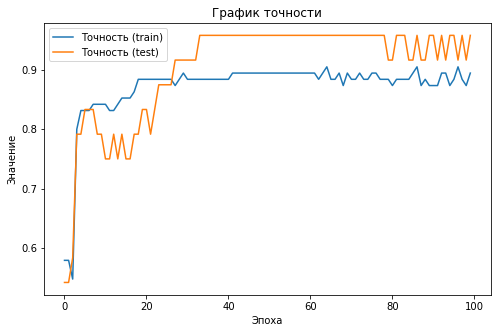

In [128]:
plt.figure(0, figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)'])

plt.figure(1, figsize=(8,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('График точности')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Точность (train)', 'Точность (test)'])

In [129]:
model = make_nn(number_data_x.shape[1], number_data_y.shape[1])

print('Начинаем обучение')
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=3,
    epochs=300,
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping( monitor='val_categorical_accuracy',
                                mode='max',
                                patience=50,
                               min_delta=0.01)
    ]
)

Начинаем обучение
Train on 95 samples, validate on 24 samples
Epoch 1/300
95/95 [==============================] - 1s 6ms/step - loss: 1.4751 - categorical_accuracy: 0.6105 - val_loss: 1.5543 - val_categorical_accuracy: 0.6250
Epoch 2/300
95/95 [==============================] - 0s 325us/step - loss: 1.4685 - categorical_accuracy: 0.6632 - val_loss: 1.5492 - val_categorical_accuracy: 0.6667
Epoch 3/300
95/95 [==============================] - 0s 336us/step - loss: 1.4620 - categorical_accuracy: 0.8105 - val_loss: 1.5438 - val_categorical_accuracy: 0.7917
Epoch 4/300
95/95 [==============================] - 0s 325us/step - loss: 1.4562 - categorical_accuracy: 0.9053 - val_loss: 1.5390 - val_categorical_accuracy: 0.8750
Epoch 5/300
95/95 [==============================] - 0s 325us/step - loss: 1.4513 - categorical_accuracy: 0.9053 - val_loss: 1.5342 - val_categorical_accuracy: 0.8750
Epoch 6/300
95/95 [==============================] - 0s 325us/step - loss: 1.4470 - categorical_accuracy:

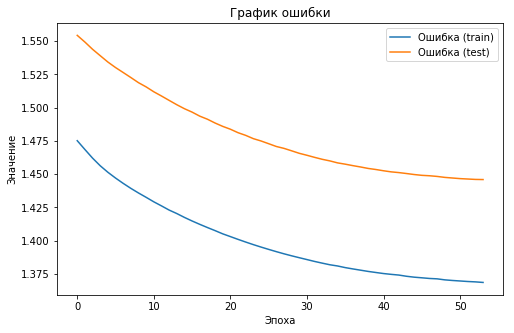

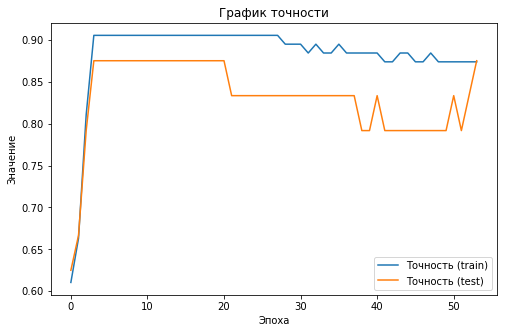

In [130]:
plt.figure(0, figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)'])

plt.figure(1, figsize=(8,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('График точности')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Точность (train)', 'Точность (test)'])

In [85]:
%matplotlib inline

In [119]:
from pathlib import Path
from os import remove

In [131]:
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{categorical_accuracy:.2f}_val_acc-{val_categorical_accuracy:.2f}.hdf5'

def make_save_points(name='save_points', file_name=file_name):
    checkpoints_dir = Path('./').joinpath('save_points')
    checkpoints_dir.mkdir(exist_ok=True)
    
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print('Удаляю' +str(item))
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

In [132]:
print('Начинаем обучение')
history = make_nn(x_train.shape[1], y_train.shape[1]).fit(
    x=x_train,
    y=y_train,
    batch_size=3,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
        monitor='val_categorical_accuracy',
        mode='max',
        patience=50,
        min_delta=0.01),
        callbacks.ModelCheckpoint(
            'rar.hdf5',
            monitor='val_categorical_accuracy',
            save_best_only=True,
            period=5,
            mode='max'
        )
    ]
)

Начинаем обучение
Train on 95 samples, validate on 24 samples
Epoch 1/300
95/95 [==============================] - 1s 6ms/step - loss: 1.5045 - categorical_accuracy: 0.5789 - val_loss: 1.5931 - val_categorical_accuracy: 0.5417
Epoch 2/300
95/95 [==============================] - 0s 325us/step - loss: 1.4942 - categorical_accuracy: 0.5789 - val_loss: 1.5803 - val_categorical_accuracy: 0.5417
Epoch 3/300
95/95 [==============================] - 0s 357us/step - loss: 1.4852 - categorical_accuracy: 0.6000 - val_loss: 1.5697 - val_categorical_accuracy: 0.5833
Epoch 4/300
95/95 [==============================] - 0s 346us/step - loss: 1.4767 - categorical_accuracy: 0.6526 - val_loss: 1.5605 - val_categorical_accuracy: 0.7083
Epoch 5/300
95/95 [==============================] - 0s 346us/step - loss: 1.4688 - categorical_accuracy: 0.8105 - val_loss: 1.5515 - val_categorical_accuracy: 0.7500
Epoch 6/300
95/95 [==============================] - 0s 315us/step - loss: 1.4618 - categorical_accuracy:

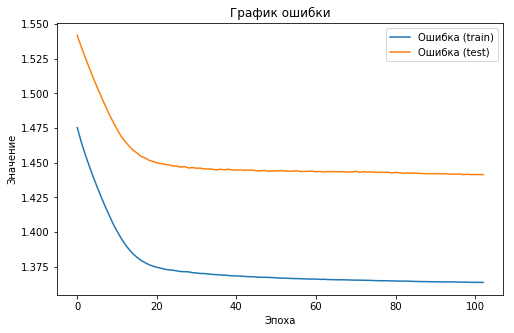

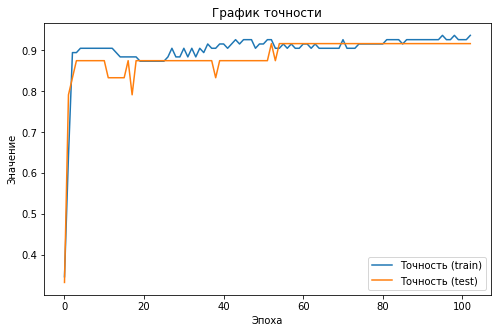

In [122]:
plt.figure(0, figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)'])

plt.figure(1, figsize=(8,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('График точности')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Точность (train)', 'Точность (test)'])

In [123]:
from keras.models import load_model

loaded_model = load_model('rar.hdf5')

print('Точность предсказания на тренировочных данных: '+str(loaded_model.evaluate(x_train, y_train)[1]))
print('Точность предсказания на тестовых данных: '+str(loaded_model.evaluate(x_test, y_test)[1]))
predict = loaded_model.predict_classes(x_test)
predict


119/119 [==============================] - 0s 1ms/step
Точность предсказания на тренировочных данных: 0.915966390562
30/30 [==============================] - 0s 0us/step
Точность предсказания на тестовых данных: 1.0


array([2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1,
       2, 2, 2, 1, 2, 2, 1], dtype=int64)

In [124]:
pipe_y.named_steps['label_encoder'].inverse_transform(predict)

array(['Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-versicolor',
       'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-virginica', 'Iris-virginica', 'Iris-versicolor',
       'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-virginica', 'Iris-virginica', 'Iris-versicolor',
       'Iris-virginica', 'Iris-versicolor', 'Iris-virginica',
       'Iris-virginica', 'Iris-versicolor', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-versicolor',
       'Iris-virginica', 'Iris-virginica', 'Iris-versicolor'], dtype=object)

In [125]:
loaded_model.predict(x_train)

array([[ 0.38963509,  0.30998021,  0.53381383],
       [ 0.14759156,  0.75032037,  0.07240485],
       [ 0.19380242,  0.66687238,  0.10878047],
       [ 0.38369736,  0.33177671,  0.52032357],
       [ 0.43021539,  0.35766244,  0.40257552],
       [ 0.39768681,  0.28131744,  0.6243096 ],
       [ 0.36045134,  0.33129567,  0.51154   ],
       [ 0.32730845,  0.37932923,  0.43829286],
       [ 0.39704373,  0.36565039,  0.44113651],
       [ 0.19546613,  0.66972077,  0.12300837],
       [ 0.52045661,  0.25203654,  0.51698214],
       [ 0.42691574,  0.35370463,  0.40051845],
       [ 0.16711222,  0.73194557,  0.07065322],
       [ 0.43226209,  0.32882649,  0.51751179],
       [ 0.40609792,  0.35543573,  0.42411223],
       [ 0.23310277,  0.63426226,  0.13399309],
       [ 0.32825789,  0.36782345,  0.47449529],
       [ 0.55400276,  0.20893466,  0.60750926],
       [ 0.4336226 ,  0.32560027,  0.37425467],
       [ 0.37557462,  0.33572203,  0.48118025],
       [ 0.3757574 ,  0.34067866,  0.494

In [126]:
def make_mashgird(x,y,h=0.2):
    x_min, x_max = x.min() -1, x.max() +1
    y_min, y_max = y.min() -1, y.max() +1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    return xx,yy
    
def plot_contours(ax, clf, xx,yy, **params):
    z = clf(xx, yy)
    z = z.reshape(xx.shape)
    out = ax.contourf(xx, yy, z, **params)
    return out

(149, 2)


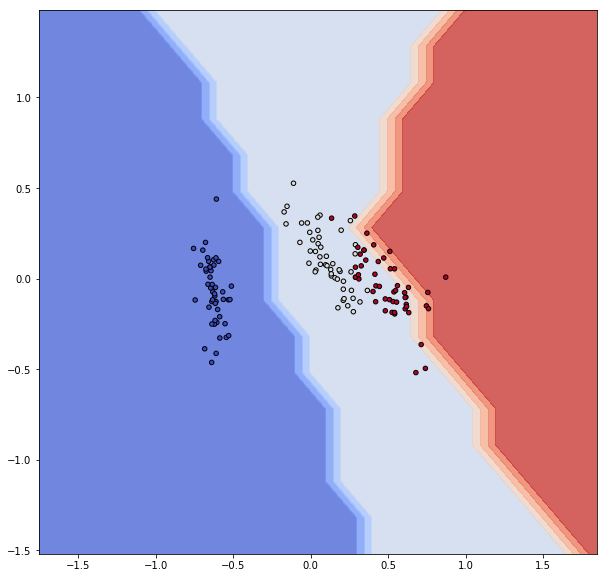

In [100]:
from sklearn.decomposition import PCA
pipe_y_mini = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder())
])

y = pipe_y_mini.fit_transform(outletless_data_y)
x = number_data_x

pca = PCA(n_components=2)

_x = pca.fit_transform(x)
print(_x.shape)

clf_predict = lambda xx, yy: model.predict_classes(pca.inverse_transform(np.c_[xx.ravel(),yy.ravel()]))

x0, x1 = _x[:, 0], _x[:, 1]
xx, yy = make_mashgird(x0, x1)

clf_predict(xx, yy)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_contours(ax, clf_predict, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(x0,x1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')